# 1. Candidate generation

In [166]:
import pandas as pd 
import numpy as np
import random


***Read Files***

In [167]:
df = pd.read_csv('data/user_videos_updated.csv')
# todo: config lại để chỉ drop na tại những cột mình xài
df = df.dropna()
df.count()


user_id               1476
user_gender           1476
user_zip              1476
dwell_time            1476
watchedAt             1476
                      ... 
discussion_density    1476
like_percentage       1476
dislike_percentage    1476
like_dislike_ratio    1476
share_percentage      1476
Length: 120, dtype: int64

In [168]:
# map user id with index
userMap = {v:k for k,v in enumerate(df['user_id'].unique())}
df['user_id'] = df['user_id'].map(userMap)
# map video id with index
videoMap = {v:k for k,v in enumerate(df['video_id'].unique())}
df['video_id'] = df['video_id'].map(videoMap)

In [169]:
t = df.groupby('video_id')['user_id'].count()
t.describe()


count    1435.000000
mean        1.028571
std         0.204258
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: user_id, dtype: float64

In [170]:
# calculate example age
df['example_age']=(pd.to_datetime("now")-pd.to_datetime(df['publishedAt']).dt.tz_localize(None))/ np.timedelta64(1,'D')

In [171]:
def normalize_col(df,col_name):
    df[col_name] = (df[col_name] - df[col_name].mean()) / (df[col_name].std() + 1e-8)
    return df

In [172]:
df['like/dislike'] = [True if x >= 160 else False for _,x in enumerate(df['dwell_time'].tolist())]
df = normalize_col(df,'example_age')
df = normalize_col(df,'dwell_time')
df = normalize_col(df,'watchTime')


In [173]:
df['like/dislike'].value_counts()

False    773
True     703
Name: like/dislike, dtype: int64

In [174]:
users = df.iloc[:,:3]
videos = df.iloc[:,7:]



In [175]:
videos['year'] = videos['publishedAt'].apply(lambda x:str(x).split('-')[0])


In [176]:
watch_cols = ['user_id', 'video_id','dwell_time','like/dislike','watchedAt']
watch = df[watch_cols]
watch['year'] = watch['watchedAt'].apply(lambda x:str(x).split('-')[0])
watch = normalize_col(watch,'dwell_time')

c:\python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [177]:
# like & dislike both false -> like
# like & dislike both true -> random false
watch['like/dislike'] = df['like/dislike']
watch['like/dislike'].unique()

array([False,  True])

In [178]:
# genres encoding
genres = df['category_term'].unique().tolist()
genres_encoded = {x: i for i,x in enumerate(genres)}
genres_encoded_2_genres = {i:x for i,x in enumerate(genres)}


# user encoding
user_ids = users['user_id'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# movie index encoding
video_ids = videos["video_id"].unique().tolist()
video2video_encoded = {x: i for i, x in enumerate(video_ids)}
video_encoded2video = {i: x for i, x in enumerate(video_ids)}

# movie title encoding
title_ids = videos['video_title'].unique().tolist()
#user_video_fond = like_dislike.pivot(index='user', columns='like/dislike', values='video').reset_index()
#user_video_fond.loc[user_video_fond['like'].isnull(),['like']] = user_video_fond.loc[user_video_fond['like'].isnull(),'like'].apply(lambda x: [dfenc['video'].max()+1] ) = {x: i for i, x in enumerate(title_ids)}
title_encoded2title = {i: x for i, x in enumerate(title_ids)}

#video category encoding 
cats = videos['category_term'].unique().tolist()
cat2cat_encoded = {x: i for i,x in enumerate(cats)}
cat_encoded2cat = {x:i for x,i in enumerate(cats)}

# genders encoding
gender_ids = users['user_gender'].unique().tolist()
gender2gender_encoded = {x: i for i, x in enumerate(gender_ids)}
gender_encoded2gender = {i: x for i, x in enumerate(gender_ids)}

#like/disklike encoding
like_dislike_ids =  watch['like/dislike'].unique().tolist()
like_dislike_ids2encoded = {x: i for i, x in enumerate(like_dislike_ids)}
encoded2like = {i: x for i, x in enumerate(like_dislike_ids)}




In [179]:
# # Only do this one time
likeMap = {True:'like', False:'dislike'}
df['like/dislike'] = df['like/dislike'].map(likeMap)

In [180]:
df['like/dislike']

0       dislike
1          like
2          like
3       dislike
4          like
         ...   
1807       like
1808    dislike
1810       like
1811       like
1813    dislike
Name: like/dislike, Length: 1476, dtype: object

In [216]:

dfenc = df
# Change to encoding
title2title_encoded = {x: i for i, x in enumerate(title_ids)}
dfenc["title_id"] = df["video_title"].map(title2title_encoded)

dfenc["user"] = df["user_id"].map(user2user_encoded)
dfenc["video"] = df["video_id"].map(video2video_encoded)
dfenc["title_d"] = df["video_title"].map(title2title_encoded)
dfenc['gender_d'] = df['user_gender'].map(gender2gender_encoded)
dfenc['cat_d'] = df['category_term'].map(cat2cat_encoded)

watch_hist = dfenc.groupby(['user'])['video_id'].apply(list).reset_index()

watch_hist_time = dfenc.groupby(['user'])['dwell_time'].apply(list).reset_index()

like_dislike = dfenc.groupby(['user','like/dislike'])['video'].apply(list).reset_index()

example_age = dfenc.groupby(['user'])['example_age'].apply(list).reset_index()


user_video_fond = like_dislike.pivot(index='user', columns='like/dislike', values='video').reset_index()
# user_video_fond.fillna(dfenc["video"].max()+1, inplace=True)
user_video_fond['like'] = user_video_fond['like'].fillna(list(dfenc['video_id'].max() + 1))

user_video_fond['dislike'] = user_video_fond['dislike'].fillna("").apply(list)


# coi lại chỗ này -> 1435 (max) đang nhiều
user_video_list = dfenc.pivot(index='user_id', columns='video_id', values='video').reset_index()
user_video_fond = like_dislike.pivot(index='user', columns='like/dislike', values='video').reset_index()


sample_data=dfenc[['user','user_gender']]
# sample_data=sample_data.reset_index()
sample_data = sample_data.drop_duplicates()

user_movie_list = pd.merge(sample_data,watch_hist, how= 'left')
user_movie_list = pd.merge(user_movie_list,watch_hist_time, how='left')
user_movie_list = pd.merge(user_movie_list,example_age, how='left')
user_movie_list = pd.merge(user_movie_list,user_video_fond,how='left')

# generate predict labels
user_movie_list['predict_labels'] = user_movie_list['video_id'].apply(lambda x: int(random.uniform(0,dfenc["video"].max()))) #label을 마지막 값으로..


# split 60:40
# train_size = user_movie_list.user.max() * 0.6
# # train_size = 10 * 0.6
# test_size = user_movie_list.user.max() - train_size
# train_data = user_movie_list[(user_movie_list.user >= 1)&
#                                   (user_movie_list.user <= tr)]
# test_data = user_movie_list[(user_movie_list.user >= train_size+1)&
#                                   (user_movie_list.user <= 10)]

TypeError: 'numpy.int64' object is not iterable

In [194]:
# user_movie_list['predict_labels'] = user_movie_list['like'].apply(lambda x: (x[-1]) )
# user_movie_list['like'] = user_movie_list['like'].apply(lambda x: x[:-1])

0                                      [0]
1                                      [3]
2                                       []
3                                      [6]
4                                      [9]
                      ...                 
143                                 [1412]
144                                     []
145    [1419, 1421, 214, 1422, 1423, 1425]
146                           [1427, 1431]
147                                 [1434]
Name: dislike, Length: 148, dtype: object

In [183]:
# split test and train set
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(user_movie_list, test_size=0.2)


In [184]:
train_data

,user,user_gender,video_id,dwell_time,example_age,dislike,like,predict_labels
16,16,Female,"[54, 55]","[-0.09104543263768633, -0.6624215027233853]","[-0.29774664695227987, -0.20751091964019702]",[55],[54],815
109,109,Male,"[942, 2, 943, 944]","[-0.5858929557786496, 14.375254089432172, -0.0...","[-0.8286368967377293, -0.7498156960918728, -0....",[942],"[2, 943, 944]",684
11,11,Female,"[45, 46, 47]","[-0.3456360520538206, -0.5792458318989031, -0....","[-0.510326269232034, -0.5581395113266695, -0.6...","[45, 46, 47]",NaN,103
46,46,Female,[328],[-0.3877010701131217],[1.8964597533334149],[328],NaN,405
92,92,Female,"[731, 732, 733, 734, 735]","[-0.6694303128133239, -0.36754998125956917, -0...","[-0.9294414497495562, -0.9262870767096745, -0....","[731, 732, 733, 734]",[735],816
...,...,...,...,...,...,...,...,...
59,59,Male,"[411, 412, 413, 414, 415, 416, 417, 418]","[-0.5754131738228352, -0.4739373965146065, -0....","[1.417203455578722, 0.5712000208370123, 1.6723...","[411, 412, 413, 416]","[414, 415, 417, 418]",767
80,80,Male,"[603, 604, 605, 606]","[-0.6153475865599131, -0.3508333917128816, -0....","[0.2669779600197809, 1.351092383128272, 0.2277...","[603, 604, 605]",[606],1215
144,144,Female,[219],[-0.16083871368506575],[-0.7801721145240679],NaN,[219],363
76,76,Female,"[550, 551, 552, 553]","[-0.6754665213296368, -0.619165047736393, -0.5...","[0.6315074010171925, 0.760741114540172, 1.8858...","[550, 551, 552, 553]",NaN,384


In [185]:
user_movie_list

,user,user_gender,video_id,dwell_time,example_age,dislike,like,predict_labels
0,0,Female,"[0, 1]","[-0.38683180745669393, 1.652215234129411]","[-0.5473293143141691, 0.3060151782165855]",[0],[1],603
1,1,Male,"[2, 3, 4]","[0.11961398944975296, -0.6393313334895335, -0....","[-0.7498156960918728, -0.8053556046304976, 0.0...",[3],"[2, 4]",452
2,2,Male,[5],[-0.12214436795436039],[0.801471251830453],NaN,[5],8
3,3,Female,"[6, 7, 8]","[-0.6794602665413363, 0.25142885709526097, 0.2...","[2.2943273329368012, 1.6946288562920635, 1.695...",[6],"[7, 8]",894
4,4,Female,[9],[-0.534658128508011],[2.066210327076784],[9],NaN,616
...,...,...,...,...,...,...,...,...
143,143,Female,"[1411, 1412, 1413, 1414, 1415, 1416, 1417]","[0.7568929342883295, -0.6447110359436492, 0.17...","[-6.120972349802609e-05, 1.7882759279366225, -...",[1412],"[1411, 1413, 1414, 1415, 1416, 1417]",995
144,144,Female,[219],[-0.16083871368506575],[-0.7801721145240679],NaN,[219],363
145,145,Female,"[1418, 1419, 1420, 1421, 214, 1422, 39, 1423, ...","[-0.009772413641608878, -0.6806669003686154, 0...","[-0.8572521146743185, -0.9136670678485954, 1.7...","[1419, 1421, 214, 1422, 1423, 1425]","[1418, 1420, 39, 1424]",574
146,146,Female,"[1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433]","[0.12305152813653554, -0.45124538604995756, 0....","[-0.37610211501928775, -0.3609177122185173, -0...","[1427, 1431]","[1426, 1428, 1429, 1430, 1432, 1433]",669


### Hyperparameter Definition

In [186]:
# CONTINUE FROM HERE - 30-09-2021
EMBEDDING_DIMS = 16
DENSE_UNITS = 64
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES= df["video_id"].max() + 2
LEARNING_RATE = 0.001

In [187]:

import tensorflow as tf
tf.random.set_seed(
    1024
)
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
#         https://www.tensorflow.org/api_docs/python/tf/ragged/boolean_mask
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}
    
class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask

In [188]:
#---inputs
import tensorflow as tf
import datetime
import os
input_watch_hist = tf.keras.Input(shape=(None, ), name='watch_hist')
input_dwell_time = tf.keras.layers.Input(shape=(None,), name='dwell_time')
input_like = tf.keras.layers.Input(shape=(None,), name='like')
input_example_age = tf.keras.Input(shape=(None, ), name='example_age')
# input_occupation = tf.keras.Input(shape=(None, ), name='occupation')


#--- layers
features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='features_embeddings')
labels_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='labels_embeddings')

avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

dense_1 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_1')
dense_2 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_2')
dense_3 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_3')
l2_norm_1 = L2NormLayer(name='l2_norm_1')

dense_output = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax, name='dense_output')

#--- features
features_embeddings = features_embedding_layer(input_watch_hist)
l2_norm_features = l2_norm_1(features_embeddings)
avg_features = avg_embeddings(l2_norm_features)

labels_watch_embeddings = labels_embedding_layer(input_dwell_time)
l2_norm_watched = l2_norm_1(labels_watch_embeddings)
avg_watched = avg_embeddings(l2_norm_watched)

labels_like_embeddings = labels_embedding_layer(input_like)
l2_norm_like = l2_norm_1(labels_like_embeddings)
avg_liked = avg_embeddings(l2_norm_like)

labels_example_age_embeddings = labels_embedding_layer(input_example_age)
l2_norm_example_age = l2_norm_1(labels_example_age_embeddings)
avg_example_age = avg_embeddings(l2_norm_example_age)

# labels_occupation_embeddings = labels_embedding_layer(input_occupation)
# l2_norm_occupation = l2_norm_1(labels_occupation_embeddings)
# avg__occupation = avg_embeddings(l2_norm_occupation)


print(avg_features)
print(avg_watched)
print(avg_liked)
print(avg_example_age)
# print(input_occupation)

# 임베딩 벡터들 연결
concat_inputs = tf.keras.layers.Concatenate(axis=1)([avg_features,
                                                     avg_watched,
                                                     avg_liked,
                                                     avg_example_age,
#                                                      avg__occupation
                                                     ])
# Dense Layers
dense_1_features = dense_1(concat_inputs)
dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
# dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

dense_3_features = dense_3(dense_2_relu)
dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)
# for ranking we use this line
# outputs = dense_output(dense_3_batch_norm) + tf.keras.layers.Softmax(dense_3_batch_norm)
# for canndidate generation
outputs = dense_output(dense_3_batch_norm)


#Optimizer
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

#--- prep model
model = tf.keras.models.Model(
    inputs=[input_watch_hist, 
            input_dwell_time, 
            input_like,
            input_example_age,
            ],
    outputs=[outputs]
)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
et = tf.keras.callbacks.EarlyStopping(
    monitor="acc",
    #min_delta=0,
    patience=50,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


# model.compile(optimizer=optimiser, loss = lambda y_pred,y_true: tf.keras.losses.CategoricalCrossentropy()(tf.keras.layers.Softmax(y_pred), y) )
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['acc'])

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='aggregate_embeddings/PartitionedCall:0', description="created by layer 'aggregate_embeddings'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='aggregate_embeddings/PartitionedCall:0', description="created by layer 'aggregate_embeddings'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='aggregate_embeddings/PartitionedCall:0', description="created by layer 'aggregate_embeddings'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='aggregate_embeddings/PartitionedCall:0', description="created by layer 'aggregate_embeddings'")
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
watch_hist (InputLayer)         [(None, None)]       

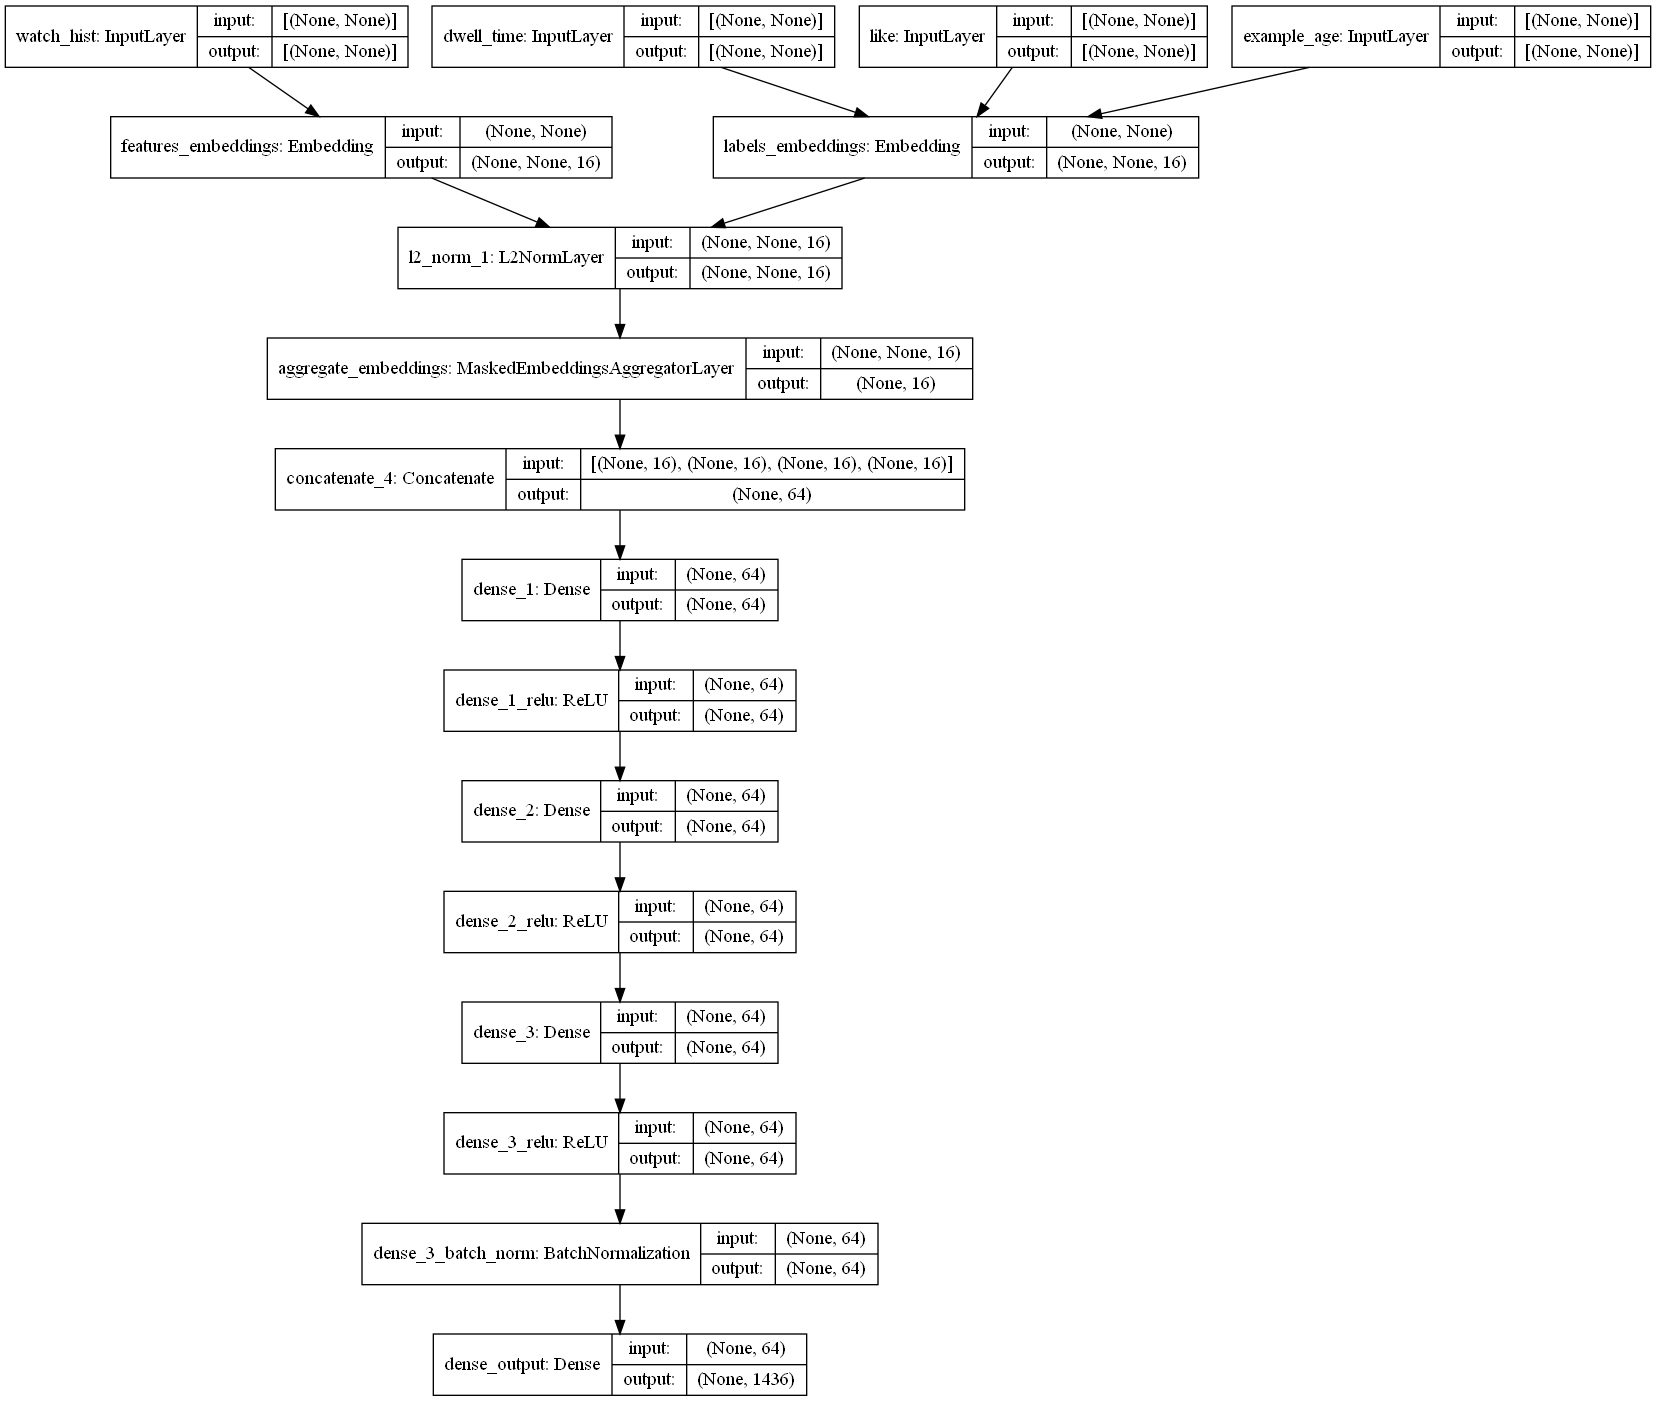

In [189]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,dpi=96)

In [190]:
history = model.fit([tf.keras.preprocessing.sequence.pad_sequences(train_data['video_id']),
           tf.keras.preprocessing.sequence.pad_sequences(train_data['dwell_time'], dtype=float),
           tf.keras.preprocessing.sequence.pad_sequences(train_data['like']) + 1e-10,
           tf.keras.preprocessing.sequence.pad_sequences(train_data['example_age'], dtype=float),
#            tf.keras.preprocessing.sequence.pad_sequences(train_data['occupation'], dtype=float),
           ],train_data['predict_labels'].values,
           steps_per_epoch=1, epochs=5000,callbacks=[et])




ValueError: `sequences` must be a list of iterables. Found non-iterable: nan

In [ ]:
model.save("candidate_generation.h5")

In [ ]:
pred = model.predict([tf.keras.preprocessing.sequence.pad_sequences(test_data['video_id']),
           tf.keras.preprocessing.sequence.pad_sequences(test_data['dwell_time'], dtype=float),
           tf.keras.preprocessing.sequence.pad_sequences(test_data['like']),
           tf.keras.preprocessing.sequence.pad_sequences(test_data['example_age'], dtype=float)
           ])

In [ ]:
pred

In [ ]:
# candidate generation: 
###### We extract the top-7 recommendation data for each user.

#???????????????????????????????????????????????????????????????????
N = 6
k = np.sort((-pred).argsort()[:,:N])
print(k)
k = k.flatten()
k[k>df["video"].max()]=0
k = np.unique(k)


In [ ]:
k

In [ ]:
title_encoded2title[302]

# 2. Ranking

### Load dmodel and preprocess data

In [ ]:
model = tf.keras.models.load_model(
    'candidate_generation.h5',
    custom_objects={
        'L2NormLayer': L2NormLayer,
        "MaskedEmbeddingsAggregatorLayer": MaskedEmbeddingsAggregatorLayer
    }
)

# custom_object: not available in tensorflow 

In [ ]:
def get_genres(movies, genres):
    def get_all_genres(gs):
        active = [str(genres_encoded[genre]) for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return '0'
        return ','.join((active))
    movies['category_term	'] = [
    get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

In [ ]:
title2title_encoded

In [ ]:
genres_encoded

In [ ]:
videos


In [ ]:
video_data = videos.set_index(['video_id']).sort_index()
video_data = video_data.loc[k+1]
video_data



In [ ]:
video_data["genre_d"] = video_data["category_term"].map(genres_encoded)
video_data["title_d"] = video_data["video_title"].map(title2title_encoded)
video_data

In [ ]:
#video_data['video_id']=video_data['title_d']
new_data = video_data.merge(df[['user_id','video_id']], on='video_id') # rating 추가

#video_data = video_data.reindex(columns=[ 'video_id', 'user_id','watchTime', 'genre_d', 'title_d','like/dislike'])
new_data= new_data[[ 'video_id', 'user_id','watchTime', 'genre_d', 'title_d','like/dislike']]
new_data['like/dislike'] = new_data['like/dislike'].map(likeMap)
new_data

In [ ]:
video_list = new_data.groupby(['user_id','like/dislike'])['video_id'].apply(list).reset_index()

video_list

In [ ]:

genre_list = new_data.groupby(['user_id'])['genre_d'].unique().apply(list).reset_index()
#genre_list['genre_d']=genre_list['genre_d'].apply(lambda x: list(set(','.join(x))) ) # 중복제거
#genre_list['genre_d']=genre_list['genre_d'].apply(lambda x:[ x for x in x if x.isdigit() ])

new_data = normalize_col(new_data, 'watchTime')
timestamp_list = new_data.groupby(['user_id'])['watchTime'].unique().apply(list).reset_index()

title_list = new_data.groupby(['user_id'])['title_d'].apply(list).reset_index()
print(video_list)
dataset = video_list.pivot(index='user_id', columns='like/dislike', values='video_id').reset_index()
dataset.fillna(new_data["video_id"].max()+1, inplace=True)

dataset['like'] =dataset['like'].apply(lambda x: x if type(x) is list else [])
dataset['dislike'] =dataset['dislike'].apply(lambda x: x if type(x) is list else [])

dataset = pd.merge(dataset, title_list, how='left')
dataset = pd.merge(dataset, genre_list, how='left')
dataset = pd.merge(dataset, timestamp_list, how='left')

dataset['predict_labels'] = dataset['like'].apply(lambda x: int(random.uniform(1,new_data["video_id"].max()))) #label을 마지막 값으로..

dataset['like']=dataset['like'].apply(lambda x: [new_data["video_id"].max()+1] if x == [] else x)
dataset['dislike']=dataset['dislike'].apply(lambda x: [new_data["video_id"].max()+1] if x == [] else x)
#train_data=dataset[(dataset.user_id >= 1)& (dataset.user_id <= 5)]
#test_data=dataset[(dataset.user_id >= 6)&(dataset.user_id <= 9)]
#dataset=dataset.drop(columns=['video_id'])

In [ ]:
# split test and train set
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.2)

In [ ]:
train_data

In [ ]:
EMBEDDING_DIMS = 16
DENSE_UNITS = 64
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES=df["video_id"].max() + 3
LEARNING_RATE = 0.0003

In [ ]:
#---inputs
import tensorflow as tf
import datetime
import os
input_title = tf.keras.Input(shape=(None, ), name='video_title')
inp_video_liked = tf.keras.layers.Input(shape=(None,), name='like')
inp_video_disliked = tf.keras.layers.Input(shape=(None,), name='dislike')
input_genre = tf.keras.Input(shape=(None, ), name='genre')
input_timestamp = tf.keras.Input(shape=(None, ), name='timestamp')
# input_occupation = tf.keras.Input(shape=(None, ), name='occupation')


#--- layers
features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='features_embeddings')
labels_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='labels_embeddings')

avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

dense_1 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_1')
dense_2 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_2')
dense_3 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_3')
l2_norm_1 = L2NormLayer(name='l2_norm_1')

dense_output = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax, name='dense_output')

#--- features
features_embeddings = features_embedding_layer(input_title)
l2_norm_features = l2_norm_1(features_embeddings)
avg_features = avg_embeddings(l2_norm_features)

labels_liked_embeddings = labels_embedding_layer(inp_video_liked)
l2_norm_liked = l2_norm_1(labels_liked_embeddings)
avg_liked = avg_embeddings(l2_norm_liked)

labels_disliked_embeddings = labels_embedding_layer(inp_video_disliked)
l2_norm_disliked = l2_norm_1(labels_disliked_embeddings)
avg_disliked = avg_embeddings(l2_norm_disliked)

labels_genre_embeddings = labels_embedding_layer(input_genre)
l2_norm_genre = l2_norm_1(labels_genre_embeddings)
avg_genre = avg_embeddings(l2_norm_genre)

labels_timestamp_embeddings = labels_embedding_layer(input_timestamp)
l2_norm_timestamp = l2_norm_1(labels_timestamp_embeddings)
avg_timestamp = avg_embeddings(l2_norm_timestamp)


# 임베딩 벡터들 연결
concat_inputs = tf.keras.layers.Concatenate(axis=1)([avg_features,
                                                     avg_liked,
                                                     avg_disliked,
                                                     avg_genre,
                                                     avg_timestamp
                                                     ])
# Dense Layers
dense_1_features = dense_1(concat_inputs)
dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
# dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

dense_3_features = dense_3(dense_2_relu)
dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)
outputs = dense_output(dense_3_batch_norm)

#Optimizer
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

#--- prep model
model = tf.keras.models.Model(
    inputs=[input_title, 
            inp_video_liked, 
            inp_video_disliked,
            input_genre,
            input_timestamp,
            ],
    outputs=[outputs]
)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['acc'])

 #model.summary()

In [ ]:
#train_data= train_data.fillna(0)
train_data

In [ ]:
history = model.fit([tf.keras.preprocessing.sequence.pad_sequences(train_data['title_d'])+ 1e-10,
           tf.keras.preprocessing.sequence.pad_sequences(train_data['like']) + 1e-10,
           tf.keras.preprocessing.sequence.pad_sequences(train_data['dislike']) + 1e-10,
            tf.keras.preprocessing.sequence.pad_sequences(train_data['genre_d']) + 1e-10,
            tf.keras.preprocessing.sequence.pad_sequences(train_data['watchTime'], dtype=float) + 1e-5,
           ],train_data['predict_labels'].values,
           steps_per_epoch=1, epochs=500)